In [63]:
import glob
import skimage.io as io
import numpy as np
import commonfunctions as cf
from skimage.feature import hog
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn import metrics
import pickle
import cv2
import random

## Load the vehicle and non-vehicle images

In [64]:
#getting images paths
vehicles_path = glob.glob("./train data/vehicles/**/*.png", recursive = True)
non_vehicles_path = glob.glob("./train data/non-vehicles/**/*.png", recursive = True)

#shuffling the ordering of images
random.shuffle(vehicles_path)
random.shuffle(non_vehicles_path)

#reading dataset
vehicles = [io.imread(vehicle_path) for vehicle_path in vehicles_path]
non_vehicles = [io.imread(non_vehicle_path) for non_vehicle_path in non_vehicles_path]

In [65]:
print("The number of vehicle images " + str(len(vehicles)))
print("The number of non vehicle images " + str(len(non_vehicles)))
print("The shape of a vehicle image " + str(np.shape(vehicles)[1:]))
print("The shape of a non vehicle image " + str(np.shape(non_vehicles)[1:]))

The number of vehicle images 8792
The number of non vehicle images 8968
The shape of a vehicle image (64, 64, 3)
The shape of a non vehicle image (64, 64, 3)


### Augmentation Stage


In [66]:
## apply the flipping augmentation
def apply_flippling_augmentation(images):
    flipped_images=images.copy()
    for index in range(len(flipped_images)):
        flipped_images[index] =np.flipud(flipped_images[index])
    return flipped_images

In [67]:
#Brightness Augmentation
#if value of a pixel was between [0-1] we can allow a pixel with a float value
#if value of a pixel was between [0-255] we should allow only a pixel with an int value, to be able to draw properly
def apply_brightness_augmentation(images, brightness_value):
    brighted_images = images.copy()
    brighted_images = brighted_images/255
    brighted_images += brightness_value
    
    leftMin = brightness_value
    leftMax = 1 + brightness_value
    rightMin = brightness_value
    rightMax = 1
    
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = (brighted_images - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    brighted_images = rightMin + (valueScaled * rightSpan)
    return brighted_images

In [68]:

def apply_rescaling_augmentation(images,rescale_value):
    images_copy=images.copy()
    rescaled_images=[]
    for index in range(len(images)):
        rescaled_images.append(rescale(images_copy[index],rescale_value, anti_aliasing=False, multichannel=True))
    return rescaled_images
    

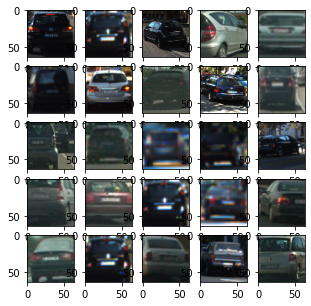

In [69]:
def show_samples(images, grid_size):
    fig = plt.figure(figsize=(grid_size, grid_size))
    patch_images = images[0:grid_size*grid_size+1]
    for i in range(1,grid_size*grid_size+1):
        fig.add_subplot(grid_size,grid_size, i)
        plt.imshow(patch_images[i-1])
    plt.show()
    
show_samples(vehicles, 5)

In [70]:
def list_splitter(list_to_split, ratio):
    elements = len(list_to_split)
    middle = int(elements * ratio)
    return list_to_split[:middle], list_to_split[middle:]

In [71]:
# Divide the data set into train and test before augmenting
vehicles_train, vehicles_test = list_splitter(vehicles,0.7)
non_vehicles_train, non_vehicles_test = list_splitter(non_vehicles,0.7)

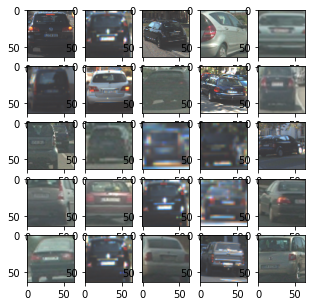

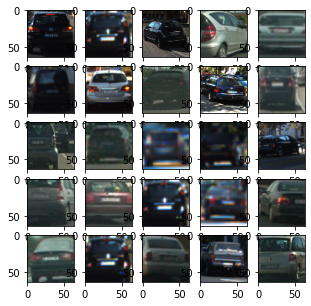

In [72]:
## apply the brightness augmentation on the dataset
brightness_value = 50/255
brighted_vehicles = apply_brightness_augmentation(np.array(vehicles_train), brightness_value)
brighted_non_vehicles = apply_brightness_augmentation(np.array(non_vehicles_train), brightness_value)

show_samples(brighted_vehicles, 5)
show_samples(vehicles_train, 5)


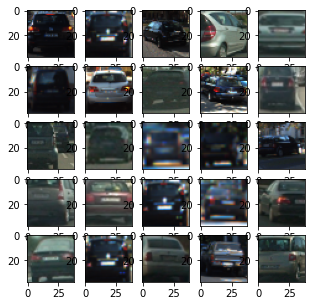

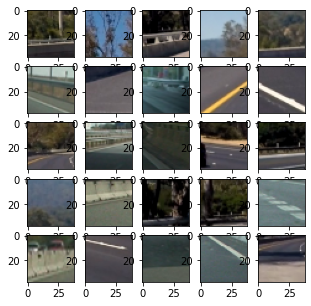

In [73]:
## apply the rescaling augmentation on the dataset
rescaling_value= 0.6
rescaled_vehicles=apply_rescaling_augmentation(vehicles_train,rescaling_value)
rescaled_non_vehicles=apply_rescaling_augmentation(non_vehicles_train,rescaling_value)
show_samples(rescaled_vehicles,5)
show_samples(rescaled_non_vehicles,5)


In [74]:
print("Size of original image = " + str(vehicles_train[1].shape))
print("Size of rescaled image = " + str(rescaled_vehicles[1].shape))

Size of original image = (64, 64, 3)
Size of rescaled image = (38, 38, 3)


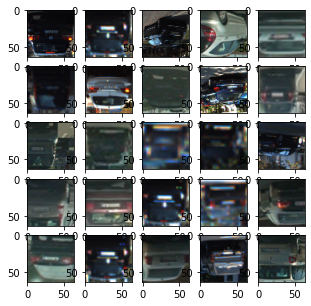

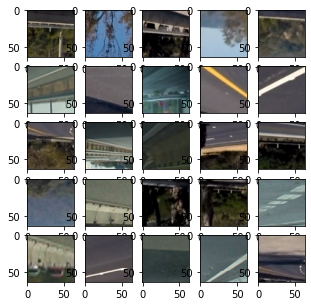

In [75]:
## apply the flipping augmentation on the dataset
flipped_vehicles=apply_flippling_augmentation(vehicles_train)
flipped_non_vehicles=apply_flippling_augmentation(non_vehicles_train)
show_samples(flipped_vehicles,5)
show_samples(flipped_non_vehicles,5)

In [76]:
##Histogram Equalization For Contrast Enhancemnet

In [77]:
def extract_hog(images):
    images_hog_features = []
    for image in images:
        hog_features= hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm='L2-Hys', visualize=False, transform_sqrt=False, feature_vector=True, multichannel=None)
        images_hog_features.append(hog_features)
    return images_hog_features

In [78]:
def apply_sift(images):
    images_sift_features = []
    flag = True
    for image in images:
        if image.dtype != 'uint8':
            image = image.astype(np.uint8)
        sift = cv2.SIFT_create()
        kp, desc = sift.detectAndCompute(image, None)
        images_sift_features.append(desc)
    return images_sift_features

In [79]:
#Chosen types of augmentation to train the model with.
augmenteted_vehicles=[vehicles_train, flipped_vehicles,brighted_vehicles]
augmenteted_non_vehicles=[non_vehicles_train, flipped_non_vehicles,brighted_non_vehicles]
print(np.shape(vehicles_train))
print(np.shape(flipped_vehicles))
print(np.shape(rescaled_vehicles))
print(np.shape(brighted_vehicles))


(6154, 64, 64, 3)
(6154, 64, 64, 3)
(6154, 38, 38, 3)
(6154, 64, 64, 3)


In [80]:
#Vstack multiple arrays together
def vstack_arrays(arrays):
    stacked_arrays = arrays[0]
    for i in range (1,len(arrays)):
        stacked_arrays = np.vstack((np.array(stacked_arrays), np.array(arrays[i])))
    return stacked_arrays

In [81]:
#Vstack the augmentation results
stacked_augmented_vehicles = vstack_arrays(augmenteted_vehicles)
stacked_augmented_non_vehicles = vstack_arrays(augmenteted_non_vehicles)

print("Shape of the total Images after all augmentation methods used" + str(np.shape(stacked_augmented_vehicles)))

Shape of the total Images after all augmentation methods used(18462, 64, 64, 3)


In [82]:
#Extract hog features from all augmented and original vehicles and non-vehicles
vehicles_hog_features = extract_hog(stacked_augmented_vehicles)
non_vehicles_hog_features = extract_hog(stacked_augmented_non_vehicles)

In [83]:
#Get sift features from all augmented and original vehicles and non-vehicles
vehicles_sift_features = apply_sift(stacked_augmented_vehicles)
non_vehicles_sift_features = apply_sift(stacked_augmented_non_vehicles)

128
128


In [84]:
print("size of the vehicles hog features = " + str(len(vehicles_hog_features[0])))
print("size of the  non vehicles hog features = " + str(len(non_vehicles_hog_features[0])))
print("size of the vehicles sift features = " + str(len(vehicles_sift_features[0])))
print("size of the  non vehicles sift features = " + str(len(non_vehicles_sift_features[0])))


size of the vehicles hog features = 2916
size of the  non vehicles hog features = 2916
size of the vehicles sift features = 25
size of the  non vehicles sift features = 29


In [85]:
#Split the data set and construct X and y
X_train = np.vstack((vehicles_hog_features,non_vehicles_hog_features)) 
y_train = np.hstack((np.ones(len(stacked_augmented_vehicles)),np.zeros(len(stacked_augmented_non_vehicles))))

In [86]:
#Train the model using cross validation
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

SVC()

In [87]:
#Preparing the test data 
vehicles_test_hog_features = extract_hog(vehicles_test)
non_vehicles_test_hog_features = extract_hog(non_vehicles_test)

In [88]:
X_test = np.vstack((vehicles_test_hog_features,non_vehicles_test_hog_features)) 
y_test = np.hstack((np.ones(len(vehicles_test)),np.zeros(len(non_vehicles_test))))

In [89]:
# Model Accuracy: how often is the classifier correct?
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9930568586976919


In [90]:
# Classification Report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2691
         1.0       0.99      0.99      0.99      2638

    accuracy                           0.99      5329
   macro avg       0.99      0.99      0.99      5329
weighted avg       0.99      0.99      0.99      5329



In [92]:
# save the model to disk
filename = 'car_detect_model.sav'
pickle.dump(clf, open(filename, 'wb'))